## Forecasting with Multiple Models


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the cleaned and normalized data
df_weather = pd.read_csv('../data/cleaned_normalized_weather.csv')

print("Data loaded successfully!")
print(df_weather.head())


Data loaded successfully!
   country  location_name  latitude  longitude  timezone  last_updated_epoch  \
0        0             88  0.700737   0.709545        98                 0.0   
1        5            168  0.524997   0.127417        44                 0.0   
2        6             52  0.002727   0.141545        45                 0.0   
3        8            198  0.838905   0.474926       157                 0.0   
4        9             26  0.760125   0.623801        84                 0.0   

          last_updated  temperature_celsius  temperature_fahrenheit  \
0  2024-05-16 13:15:00             0.583113                0.581498   
1  2024-05-16 04:45:00             0.567282                0.566814   
2  2024-05-16 05:45:00             0.092348                0.091043   
3  2024-05-16 10:45:00             0.303430                0.302496   
4  2024-05-16 12:45:00             0.329815                0.328928   

   condition_text  ...  air_quality_PM2.5  air_quality_PM10  \
0  

In [2]:
# Features and target
X = df_weather.drop(columns=['temperature_celsius', 'last_updated'])
y = df_weather['temperature_celsius']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVR": SVR(kernel='rbf'),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200,random_state=42),
    "Linear Regression": LinearRegression(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror',learning_rate=0.05, n_estimators=200, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append([name, mae, rmse, r2])

# Results summary
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²'])
print(results_df.sort_values(by='R²', ascending=False))


               Model       MAE      RMSE        R²
5      Random Forest  0.000185  0.000515  0.999991
6  Linear Regression  0.000495  0.000615  0.999987
0      Decision Tree  0.000171  0.000677  0.999984
3  Gradient Boosting  0.000910  0.001318  0.999939
7            XGBoost  0.000834  0.001805  0.999886
4           AdaBoost  0.008239  0.010722  0.995988
2                KNN  0.102677  0.135278  0.361428
1                SVR  0.107970  0.139584  0.320128


In [4]:
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Ensemble of top performers
ensemble = VotingRegressor([
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42, eval_metric='rmse')),
    ('gbr', GradientBoostingRegressor(random_state=42)),
    ('ada', AdaBoostRegressor(random_state=42)),
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('svr', SVR(kernel='rbf')),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('lr', LinearRegression())
])

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_ensemble)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
r2 = r2_score(y_test, y_pred_ensemble)

print("\n--- Ensemble Model Performance ---")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")



--- Ensemble Model Performance ---
MAE:  0.025
RMSE: 0.033
R²:   0.962


C:\Users\Ahmed Sherif\AppData\Local\Temp\ipykernel_9868\411866426.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R²', palette='coolwarm')


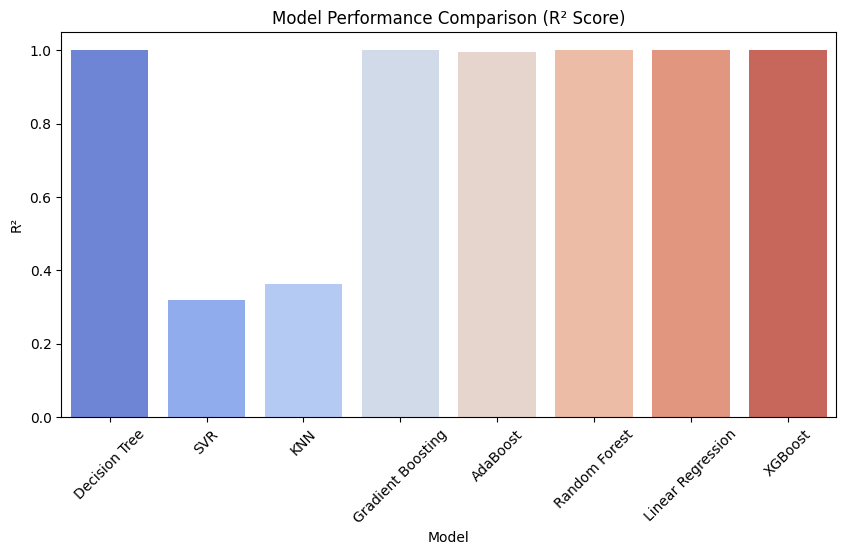

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x='Model', y='R²', palette='coolwarm')
plt.title('Model Performance Comparison (R² Score)')
plt.xticks(rotation=45)
plt.show()


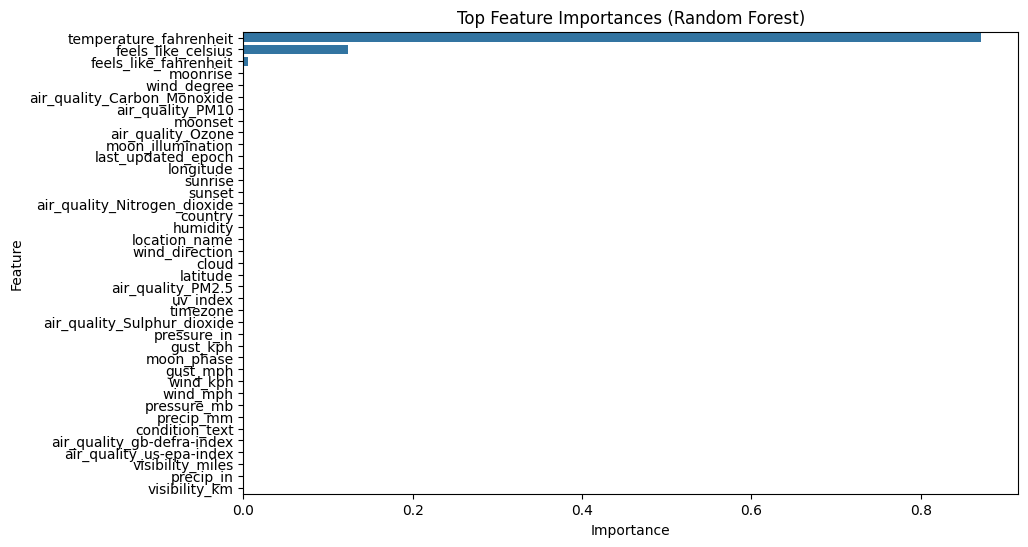

In [6]:
importances = ensemble.estimators_[0].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Top Feature Importances (Random Forest)')
plt.show()


In [7]:
results_df.to_csv('../results/forecasting_model_comparison.csv', index=False)
print("Model comparison saved to 'forecasting_model_comparison.csv'")


Model comparison saved to 'forecasting_model_comparison.csv'


## Save the model 

In [8]:
import joblib

# Save the ensemble model
joblib.dump(ensemble, '../models/forecasting_ensemble_model.pkl')

print("Ensemble model saved successfully as 'forecasting_ensemble_model.pkl'")


Ensemble model saved successfully as 'forecasting_ensemble_model.pkl'


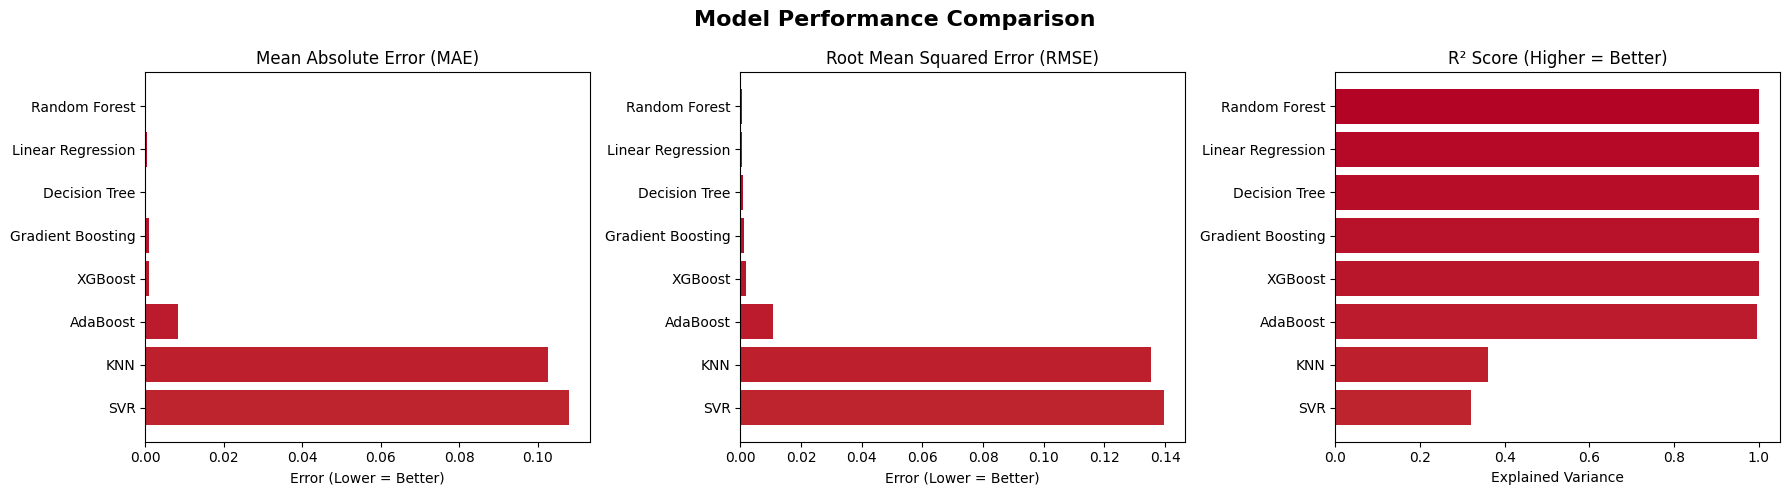

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Model results
data = {
    'Model': [
        'Random Forest', 'Linear Regression', 'Decision Tree', 'Gradient Boosting',
        'XGBoost', 'AdaBoost', 'KNN', 'SVR'
    ],
    'MAE': [0.000185, 0.000495, 0.000171, 0.000910, 0.000834, 0.008239, 0.102677, 0.107970],
    'RMSE': [0.000515, 0.000615, 0.000677, 0.001318, 0.001805, 0.010722, 0.135278, 0.139584],
    'R²': [0.999991, 0.999987, 0.999984, 0.999939, 0.999886, 0.995988, 0.361428, 0.320128]
}

df_results = pd.DataFrame(data)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = plt.cm.coolwarm_r(range(len(df_results)))

# MAE
axes[0].barh(df_results['Model'], df_results['MAE'], color=colors)
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].invert_yaxis()
axes[0].set_xlabel('Error (Lower = Better)')

# RMSE
axes[1].barh(df_results['Model'], df_results['RMSE'], color=colors)
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].invert_yaxis()
axes[1].set_xlabel('Error (Lower = Better)')

# R²
axes[2].barh(df_results['Model'], df_results['R²'], color=colors)
axes[2].set_title('R² Score (Higher = Better)')
axes[2].invert_yaxis()
axes[2].set_xlabel('Explained Variance')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## Thanks